<a href="https://colab.research.google.com/github/Andribi/A2MF_AP/blob/main/ProvaFacebookPGAN_coorts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTKFace 


In [ ]:
# DRIVE MOUNT
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# REPOSITORY CLONE
!git clone https://github.com/Andribi/A2MF_AP.git

Cloning into 'A2MF_AP'...
remote: Enumerating objects: 241924, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 241924 (delta 70), reused 101 (delta 52), pack-reused 241796
Receiving objects: 100% (241924/241924), 2.38 GiB | 18.49 MiB/s, done.
Resolving deltas: 100% (143/143), done.
Updating files: 100% (242769/242769), done.


In [7]:
# LIBRARIES
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=de5fdc7bd95bf76f94e4adb1b67f5b02b01757cb0acc6095a9e51a58f71d2db2
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
cata

In [8]:
# IMPORTS DATA ANALYSIS
import os 
import json 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import face_recognition
from face_recognition import face_locations

# MLP IMPORTS
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, confusion_matrix #plot_confusion_matrix ???????

# CNN IMPORTS
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from PIL import Image
from pathlib import Path

In [9]:
# GLOBAL VARS
UTKFACE_DIR = '/content/A2MF_AP/UTKFace/'
UTKFACE_PATH = '/content/A2MF_AP/UTKFace/utkface'
UTKFACE_BAL_PATH = '/content/A2MF_AP/UTKFace/utkface_bal'
UTKFACE_SK_PATH = '/content/A2MF_AP/UTKFace/utkface_sk'
UTKFACE_LABELS_PATH = '/content/A2MF_AP/UTKFace/utkface.json'
UTKFACE_ATTR_PATH = '/content/A2MF_AP/UTKFace/utkface_attr.json'
UTKFACE_ATTR_UNBAL_PATH = '/content/A2MF_AP/UTKFace/utkface_attr_unbal.json'

UTKFACE_CONFIG_PATH = '/content/A2MF_AP/UTKFace/utkface_config.json'
UTKFACE_FEATURE_CSV_PATH = '/content/A2MF_AP/UTKFace/feature.csv'
UTKFACE_LABEL_CSV_PATH = '/content/A2MF_AP/UTKFace/label.csv'

UTKFACE_FEATURE_CU_CSV_PATH = '/content/A2MF_AP/UTKFace/feature_CU.csv'
UTKFACE_LABEL_CU_CSV_PATH = '/content/A2MF_AP/UTKFace/label_CU.csv'

UTKFACE_DF_CSV_PATH = '/content/A2MF_AP/UTKFace/utkface_df.csv'
UTKFACE_OHE_PATH = '/content/A2MF_AP/UTKFace/utkface_ohe.csv'
UTKFACE_COORTS_UNBAL_PATH = '/content/A2MF_AP/UTKFace/utkface_coorts_unbal.csv'

MODEL_CHKP_CNN_PATH = "/content/A2MF_AP/UTKFace/AGR_recognition/CNN_CU_face_model"
MODEL_CHKP_MLP_PATH = '/content/A2MF_AP/UTKFace/AGR_recognition/MLP_CU_face_model.pkl'

#MODEL_CHKP_CNN_LOAD_PATH = "/content/A2MF_AP/UTKFace/AGR_recognition/CNN_face_model"
#MODEL_CHKP_MLP_LOAD_PATH = '/content/A2MF_AP/UTKFace/AGR_recognition/MLP_face_model.pkl'


## Data Analysis 

In [10]:
# LABEL CREATION 
'''
This script generates a json file with the labels for the utkface dataset.
The labels of each face image is embedded in the file name, 
formated like [age]_[gender]_[race]_[date&time].jpg
[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting 
White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, 
showing the date and time an image was collected to UTKFace
source: https://susanqq.github.io/UTKFace/
'''

if not UTKFACE_LABELS_PATH:
  res = {}
  print('Creating  labels in utkface.json')
  feat_names = ['age', 'gender', 'race']
  for pic in os.listdir(UTKFACE_PATH):
      features = pic.split('_')[:-1]
      features_dict = {}
      for i in range(len(features)):
          features_dict[feat_names[i]] = int(features[i])
      res[pic] = features_dict
  with open(UTKFACE_LABELS_PATH, 'w') as outfile:
      json.dump(res, outfile)
else:
  print('Labels aready in UTKFace directory')

Labels aready in UTKFace directory


In [11]:
# CREATE DATAFRAME
with open(UTKFACE_LABELS_PATH) as utkface:
    utkface_dict = json.load(utkface)

utkface_df = pd.DataFrame.from_dict(utkface_dict, orient='index')
print('Number of images in UTKFace: ', utkface_df.shape[0])
utkface_df.head(5)

Number of images in UTKFace:  23672


,age,gender,race
37_0_3_20170119202516470.jpg.chip.jpg,37,0,3.0
15_0_0_20170110225705232.jpg.chip.jpg,15,0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,45,0,3.0
53_0_3_20170119201334485.jpg.chip.jpg,53,0,3.0
22_0_1_20170113193211629.jpg.chip.jpg,22,0,1.0


In [12]:
# MISSING VALUES
print('Percentage of missing values:', 
      round((utkface_df.isna().sum().sum()/utkface_df.shape[0]) * 100 , 2), '%')
nan_vals = utkface_df[utkface_df.isna().any(axis=1)]
utkface_df = utkface_df.dropna()
print('Percentage of missing values after drop:', 
      round((utkface_df.isna().sum().sum()/utkface_df.shape[0]) * 100 , 2), '%')

print('Number of images in UTKFace after drop: ', utkface_df.shape[0])

Percentage of missing values: 0.01 %
Percentage of missing values after drop: 0.0 %
Number of images in UTKFace after drop:  23669


In [13]:
# RACE CLASSES
utkface_df['race'] = utkface_df['race'].apply(np.int64)
utkface_df = utkface_df.drop(utkface_df[utkface_df['race'] == 4].index)

# AGE CLASSES
utkface_df.loc[utkface_df.age < 15, 'age'] = 0
utkface_df.loc[((utkface_df.age >= 15) & (utkface_df.age <25)), 'age'] = 1
utkface_df.loc[((utkface_df.age >= 25) & (utkface_df.age <65)), 'age'] = 2
utkface_df.loc[((utkface_df.age >= 65) & (utkface_df.age <85)), 'age'] = 3
utkface_df.loc[utkface_df.age >= 85, 'age'] = 4

# dataframe to use for cnn (recognition)
cnn_df = utkface_df.copy()

In [14]:
# REDEFINITION
print('Samples after class redefinition: ' + str(utkface_df.shape[0]))
utkface_df.head(5)

Samples after class redefinition: 21981


,age,gender,race
37_0_3_20170119202516470.jpg.chip.jpg,2,0,3
15_0_0_20170110225705232.jpg.chip.jpg,1,0,0
45_0_3_20170119171425106.jpg.chip.jpg,2,0,3
53_0_3_20170119201334485.jpg.chip.jpg,2,0,3
22_0_1_20170113193211629.jpg.chip.jpg,1,0,1


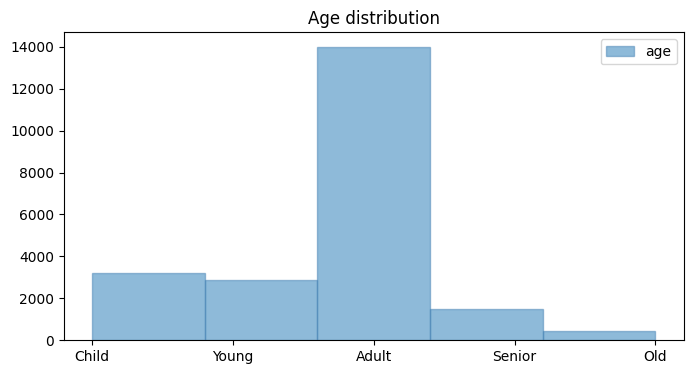

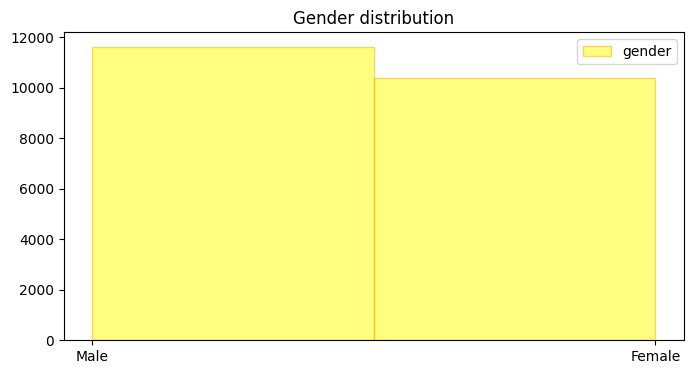

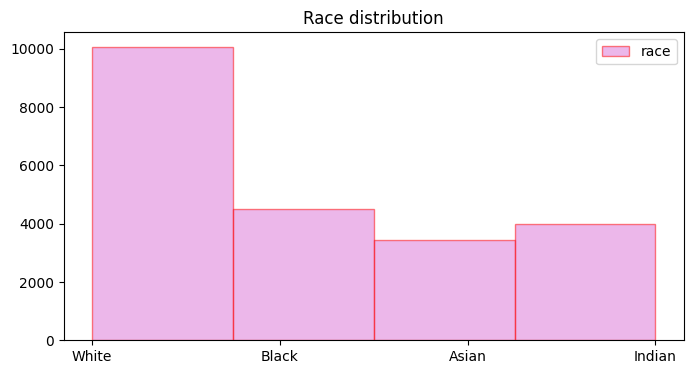

In [15]:
# PLOT DISTRIBUTIONS

def plot_distr(df):
    age = df["age"].astype(int).sort_values()
    age_bins=len(age.value_counts())

    gender = df["gender"].astype(int).sort_values()
    gender_bins=len(gender.value_counts())

    race = df["race"].astype(int).sort_values()
    race_bins=len(race.value_counts())

    age.hist(bins=age_bins, figsize=[8,4], edgecolor='steelblue', 
            linewidth=1, grid=False, alpha=0.5, legend=True)
    plt.title('Age distribution')
    plt.xticks(np.arange(0, 5, step=1), ['Child', 'Young', 'Adult', 'Senior', 'Old'])
    plt.show()

    gender.hist(bins=gender_bins, figsize=[8,4], edgecolor='orange', 
                linewidth=1, grid=False, alpha=0.5, legend=True, color='yellow')
    plt.title('Gender distribution')
    plt.xticks(np.arange(0, 2, step=1), ['Male', 'Female'])
    plt.show()

    race.hist(bins=race_bins, figsize=[8,4], edgecolor='red', 
              linewidth=1, grid=False, alpha=0.5, legend=True, color='orchid')
    plt.xticks(np.arange(0, 4, step=1), ['White', 'Black', 'Asian', 'Indian'])
    plt.title('Race distribution')
    plt.show()


plot_distr(utkface_df)

In [ ]:
# SAVE ANALYSED DATA

list_utkface = os.listdir(UTKFACE_DIR)
if ('utkface_df.csv' in list_utkface):
    print('CSVs already present')
else:
  # utkface_df ATTRIBUTES CSV 
  utkface_df.to_csv(UTKFACE_DF_CSV_PATH) 

CSVs already present


###Training GAN preparation
Data for training to create synthetic images

In [16]:
# CLONE DF

to_train_df = utkface_df.copy()
to_train_df.head(5)

,age,gender,race
37_0_3_20170119202516470.jpg.chip.jpg,2,0,3
15_0_0_20170110225705232.jpg.chip.jpg,1,0,0
45_0_3_20170119171425106.jpg.chip.jpg,2,0,3
53_0_3_20170119201334485.jpg.chip.jpg,2,0,3
22_0_1_20170113193211629.jpg.chip.jpg,1,0,1


In [17]:
# ONE HOT ENCODING

def one_hot_enc(df):
    df_one_hot_enc = pd.get_dummies(df, 
                                columns=["age", "gender", "race"], 
                                dtype=float)
    df_one_hot_enc = df_one_hot_enc.rename({'age_0' : 'child', 
                                            'age_1' : 'young', 
                                            'age_2' : 'adult', 
                                            'age_3' : 'senior', 
                                            'age_4' : 'old', 
                                            'gender_0' : 'male', 
                                            'gender_1' : 'female', 
                                            'race_0' : 'white', 
                                            'race_1' : 'black', 
                                            'race_2' : 'asian',
                                            'race_3' : 'indian'}, 
                                             axis=1)
    return df_one_hot_enc

to_train_df = one_hot_enc(to_train_df)
#utkface_bal = one_hot_enc(utkface_bal)
to_train_df.head(5)

,child,young,adult,senior,old,male,female,white,black,asian,indian
37_0_3_20170119202516470.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15_0_0_20170110225705232.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
53_0_3_20170119201334485.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22_0_1_20170113193211629.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [18]:
# FEMALE CLASS DROP (REMOVE REDUDANCE)

to_train_df_dropped = to_train_df.drop(columns=['female'])
#utkface_bal = utkface_bal.drop(columns=['female'])
to_train_df_dropped.head()

,child,young,adult,senior,old,male,white,black,asian,indian
37_0_3_20170119202516470.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15_0_0_20170110225705232.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
53_0_3_20170119201334485.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
22_0_1_20170113193211629.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


**COMBINED** **COORTS**

In [19]:
prova = to_train_df

res = pd.DataFrame(index=prova.index)

AGE = prova.columns[:5]
GENDER = prova.columns[5:7]
ETHNICITY = prova.columns[7:]

new_cols = []
for a in AGE:
  for g in GENDER:
    for e in ETHNICITY:
      res["{}+{}+{}".format(a, g, e)] = prova[a] * prova[g] * prova[e]

to_train_df = res
res

,child+male+white,child+male+black,child+male+asian,child+male+indian,child+female+white,child+female+black,child+female+asian,child+female+indian,young+male+white,young+male+black,...,senior+female+asian,senior+female+indian,old+male+white,old+male+black,old+male+asian,old+male+indian,old+female+white,old+female+black,old+female+asian,old+female+indian
37_0_3_20170119202516470.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15_0_0_20170110225705232.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53_0_3_20170119201334485.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22_0_1_20170113193211629.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28_0_3_20170119194506507.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_1_2_20161219155922221.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37_0_3_20170104232806122.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23_1_3_20170119164326981.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[710, 86, 509, 246, 780, 109, 461, 297, 486, 245, 137, 175, 666, 346, 414, 383, 3606, 1823, 780, 1750, 2453, 1675, 911, 992, 576, 139, 118, 83, 485, 54, 28, 26, 85, 19, 28, 6, 212, 22, 44, 16]


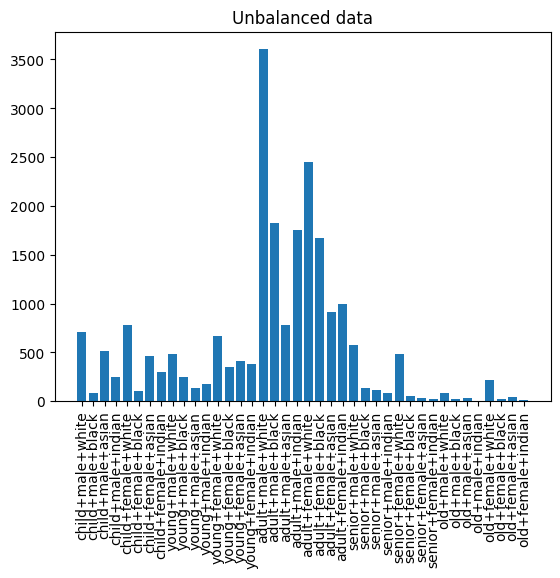

In [20]:
attr_unbal = []
for col in to_train_df.columns:
  attr_unbal.append(to_train_df[col].astype(int).value_counts()[1])

print(attr_unbal)

plt.bar(to_train_df.columns, attr_unbal)
plt.xticks(to_train_df.columns, rotation='vertical')
plt.rcParams["figure.figsize"] = (2^16-1,2^16-1)
plt.title('Unbalanced data')
plt.show()

In [21]:
%cd 'A2MF_AP/UTKFace'
!mkdir utkface_bal
%cd '/content'
!pwd

/content/A2MF_AP/UTKFace
/content
/content


[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


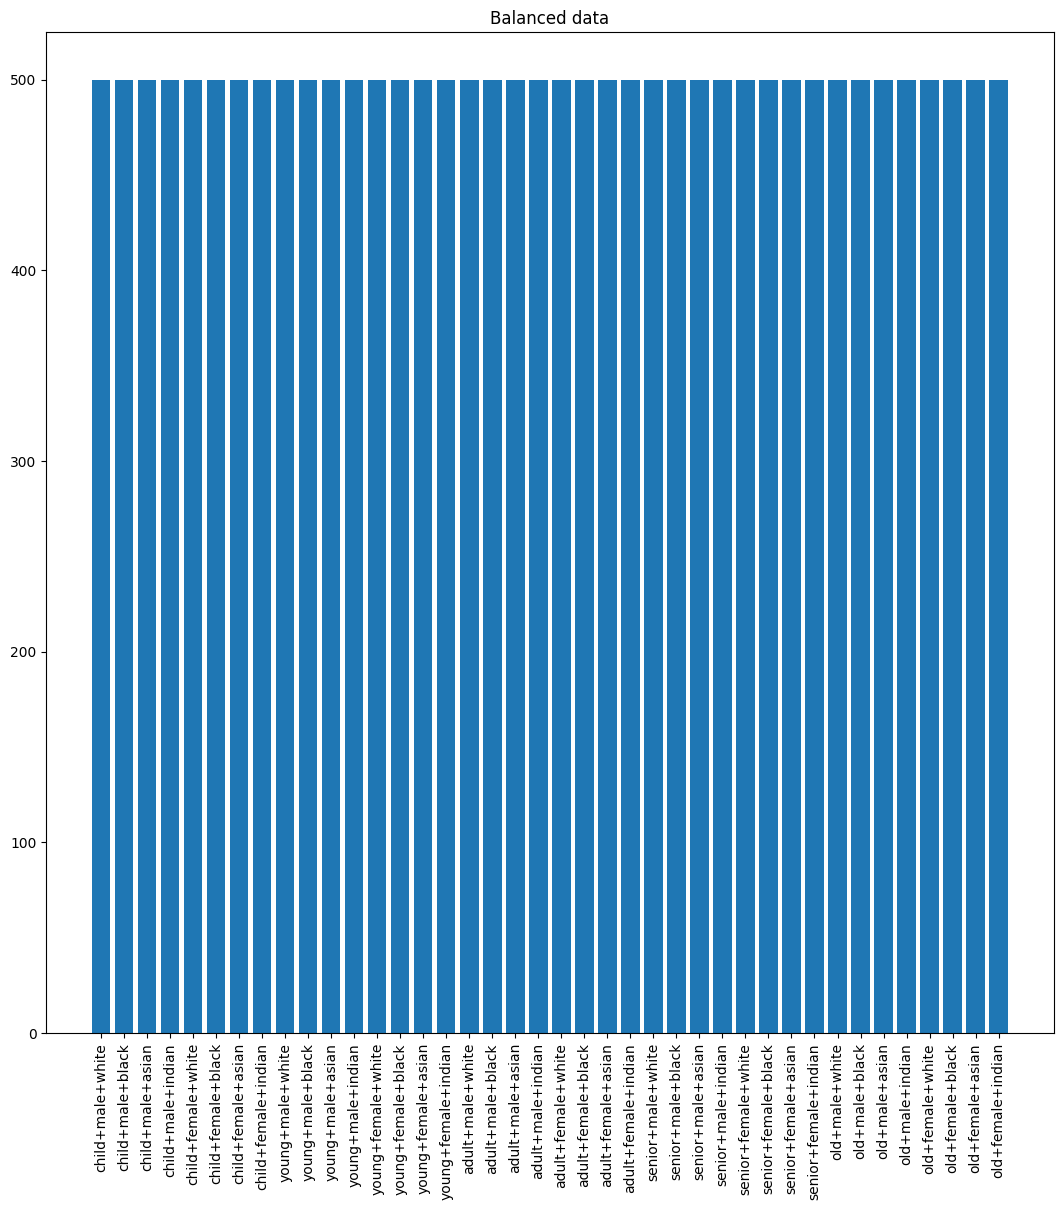

In [22]:
THRESHOLD = 500
to_train_df_bal = to_train_df.groupby(list(to_train_df.columns)).sample(n=THRESHOLD, replace=True, random_state=777)



attr_bal = []
for col in to_train_df_bal.columns:
  attr_bal.append(to_train_df_bal[col].astype(int).value_counts()[1])

print(attr_bal)


plt.bar(to_train_df_bal.columns, attr_bal)
plt.xticks(to_train_df_bal.columns, rotation='vertical')
plt.rcParams["figure.figsize"] = (2^16-1,2^16-1)
plt.title('Balanced data')
plt.show()



In [ ]:
# SAVE UTKFACE ONE-HOT ENC DATA

list_utkface = os.listdir(UTKFACE_DIR)
if ('utkface_coorts_unbal.csv' in list_utkface):
    print('CSVs already present')
else:
  # utkface_df_ohe CSV 
  to_train_df.to_csv(UTKFACE_COORTS_UNBAL_PATH) 

In [ ]:
# SAVE DATA FOR TRAINING 
attr_dict = to_train_df.to_json(orient='index')
with open(UTKFACE_ATTR_UNBAL_PATH, 'w') as outfile:
    json.dump(json.loads(attr_dict), outfile)

## Age Race Gender Recognition




### Method 1: MLP

Source: https://github.com/wondonghyeon/face-classification/blob/master/train.ipynb


In [ ]:
# LOAD MLP DATA
to_train_df = pd.read_csv(UTKFACE_COORTS_UNBAL_PATH, index_col=0)

In [ ]:
# CSV FEATURE AND LABEL CREATION FOR MLP

list_utkface = os.listdir(UTKFACE_DIR)
if ('feature_CU.csv' in list_utkface and 'label_CU.csv' in list_utkface):
  print('CSVs already present')
else:
  vecs = []
  fnames = []
  i = 0
  for fname in tqdm(to_train_df.index): 
      i += 1
      img_path = UTKFACE_PATH + '/' + fname
      X_img = face_recognition.load_image_file(img_path)
      X_faces_loc = face_locations(X_img)
      if len(X_faces_loc) != 1:
          continue
      faces_encoding = face_recognition.face_encodings(X_img, known_face_locations=X_faces_loc)[0]
      vecs.append(faces_encoding)
      fnames.append(fname)
      
  df_feat_coorts_unbal = pd.DataFrame(vecs, index=fnames)
  df_label_coorts_unbal = to_train_df[to_train_df.index.isin(df_feat_coorts_unbal.index)]
  df_feat_coorts_unbal.sort_index(inplace=True)
  df_label_coorts_unbal.sort_index(inplace=True)
  df_feat_coorts_unbal.to_csv(UTKFACE_FEATURE_CU_CSV_PATH)
  df_label_coorts_unbal.to_csv(UTKFACE_LABEL_CU_CSV_PATH)

CSVs already present


In [ ]:
df_feat_coorts_unbal.head(5)

NameError: ignored

In [ ]:
df_label_coorts_unbal.head(5)

,child+male+white,child+male+black,child+male+asian,child+male+indian,child+female+white,child+female+black,child+female+asian,child+female+indian,young+male+white,young+male+black,...,senior+female+asian,senior+female+indian,old+male+white,old+male+black,old+male+asian,old+male+indian,old+female+white,old+female+black,old+female+asian,old+female+indian
100_0_0_20170112213500903.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100_0_0_20170112215240346.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100_1_0_20170110183726390.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100_1_0_20170112213001988.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100_1_0_20170112213303693.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# DATASET SPLIT MLP

# load features and labels
df_feat_coorts_unbal = pd.read_csv(UTKFACE_FEATURE_CU_CSV_PATH, index_col=0)
df_label_coorts_unbal = pd.read_csv(UTKFACE_LABEL_CU_CSV_PATH, index_col=0)

# load utkface_df
cnn_df = pd.read_csv(UTKFACE_DF_CSV_PATH, index_col=0)

# split training/test name
idx_train, idx_test = train_test_split(df_feat_coorts_unbal.index, test_size = 0.30, random_state = 123)

# train/test for MLP
X_train_mlp, Y_train_mlp = df_feat_coorts_unbal.loc[idx_train], df_label_coorts_unbal.loc[idx_train]
X_test_mlp, Y_test_mlp = df_feat_coorts_unbal.loc[idx_test], df_label_coorts_unbal.loc[idx_test]

print('Number of total samples:         ', df_label_coorts_unbal.shape[0])
print('Number of elements in train set: ', idx_train.shape[0])
print('Number of elements in test set:  ', idx_test.shape[0])

Number of total samples:          21185
Number of elements in train set:  14829
Number of elements in test set:   6356


[487, 50, 344, 170, 537, 74, 305, 195, 319, 159, 90, 132, 452, 238, 280, 272, 2477, 1199, 523, 1188, 1631, 1136, 616, 683, 381, 84, 72, 56, 329, 33, 23, 18, 59, 11, 20, 1, 143, 11, 23, 8]


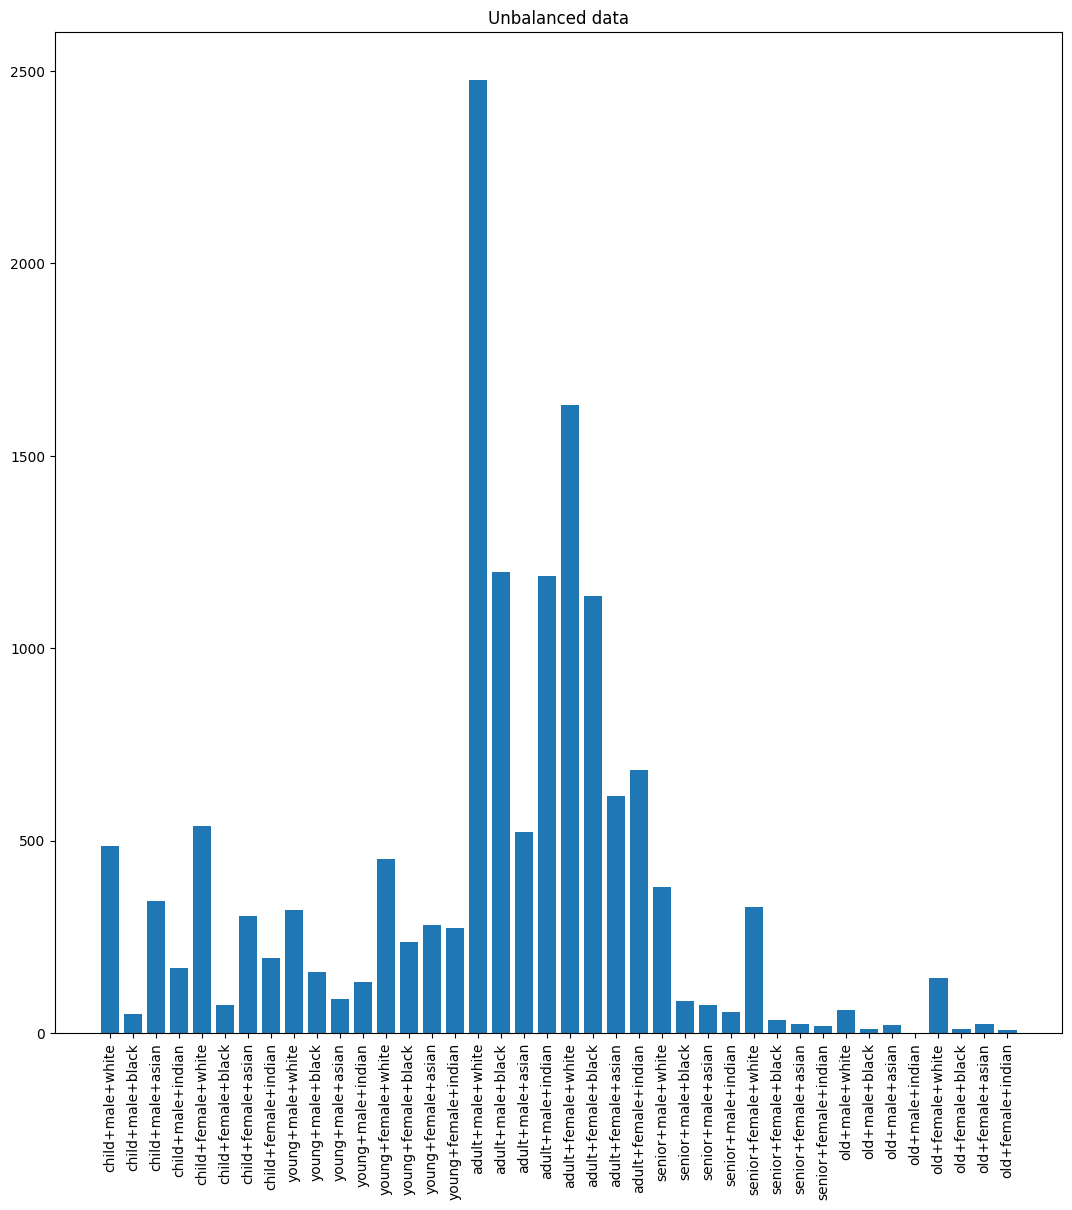

In [ ]:
# DATA VISUALIZATION MLP
attr_count = []
for col in Y_train_mlp.columns:
  attr_count.append(Y_train_mlp[col].astype(int).value_counts()[1])

print(attr_count)

plt.bar(Y_train_mlp.columns, attr_count)
plt.xticks(to_train_df_bal.columns, rotation='vertical')
plt.title('Unbalanced data')
plt.show()

In [ ]:
# MLP CLASSIFIER 

if 'MLP_CU_face_model.pkl' not in os.listdir('/content/A2MF_AP/UTKFace/AGR_recognition/'):
  clf = MLPClassifier(solver='adam', 
                      hidden_layer_sizes=(128, 128),
                      max_iter = 5000, 
                      verbose=True, 
                      tol=1e-4, 
                      activation='relu')
  print(Y_train_mlp.head())
  clf.fit(X_train_mlp, Y_train_mlp)

  # save model
  with open(MODEL_CHKP_MLP_PATH, 'wb') as f:
      pickle.dump([clf, df_label_coorts_unbal.columns.tolist()], f)
      label_list = df_label_coorts_unbal.columns.tolist()

else:
  clf, label_list = pickle.load(open(MODEL_CHKP_MLP_PATH,'rb'))


# MLP model prediction
pred = clf.predict(X_test_mlp)
score = clf.predict_proba(X_test_mlp)

df_pred = pd.DataFrame(pred, columns=label_list, index=Y_test_mlp.index)
df_score = pd.DataFrame(score, columns=label_list, index=Y_test_mlp.index)

                                       child+male+white  child+male+black  \
30_1_2_20170105170141222.jpg.chip.jpg               0.0               0.0   
25_0_0_20170116211924733.jpg.chip.jpg               0.0               0.0   
2_0_2_20161219191202354.jpg.chip.jpg                0.0               0.0   
3_1_0_20161219225130536.jpg.chip.jpg                0.0               0.0   
36_0_0_20170104174512284.jpg.chip.jpg               0.0               0.0   

                                       child+male+asian  child+male+indian  \
30_1_2_20170105170141222.jpg.chip.jpg               0.0                0.0   
25_0_0_20170116211924733.jpg.chip.jpg               0.0                0.0   
2_0_2_20161219191202354.jpg.chip.jpg                1.0                0.0   
3_1_0_20161219225130536.jpg.chip.jpg                0.0                0.0   
36_0_0_20170104174512284.jpg.chip.jpg               0.0                0.0   

                                       child+female+white  child+fem

In [ ]:
# MLP METRICS
cm_age = confusion_matrix(Y_test_mlp.iloc[:, :4].values.argmax(axis=1), 
                          df_pred.iloc[:, :4].values.argmax(axis=1))
cm_gen = confusion_matrix(Y_test_mlp.iloc[:, 4:5].values.argmax(axis=1), 
                          df_pred.iloc[:, 4:5].values.argmax(axis=1))
cm_race = confusion_matrix(Y_test_mlp.iloc[:, 5:].values.argmax(axis=1), 
                           df_pred.iloc[:, 5:].values.argmax(axis=1))

report = classification_report(Y_test_mlp.values, 
                               df_pred.values, 
                               target_names=Y_test_mlp.columns)

print('CM AGE:\n', cm_age)
print('\nCM GEN:\n', cm_gen)
print('\nCM RACE:\n', cm_race)

print('\nREPORT:\n', report)

CM AGE:
 [[6023   14   50   37]
 [  15   13    1    1]
 [  65    0   70    0]
 [  36    0    0   31]]

CM GEN:
 [[6356]]

CM RACE:
 [[533  62  20 ...   0   0   0]
 [ 50  65   0 ...   0   0   0]
 [ 33   3  43 ...   0   0   0]
 ...
 [  2   0   0 ...   0   0   0]
 [  4   0   0 ...   0   4   0]
 [  2   0   0 ...   0   0   0]]

REPORT:
                       precision    recall  f1-score   support

    child+male+white       0.54      0.59      0.57       198
    child+male+black       0.48      0.43      0.46        30
    child+male+asian       0.58      0.53      0.55       135
   child+male+indian       0.44      0.48      0.46        67
  child+female+white       0.58      0.60      0.59       218
  child+female+black       0.32      0.30      0.31        30
  child+female+asian       0.50      0.55      0.52       119
 child+female+indian       0.60      0.52      0.55        89
    young+male+white       0.38      0.41      0.40       151
    young+male+black       0.34      0.38    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Method 2: CNN

Source: https://github.com/Sobika2531/Age-Gender-And-Race-Detection-Using-CNN/blob/main/AGRdetector.ipynb

In [23]:
# CNN
def conv_block(inp, filters=8, bn=True, pool=True):
    _ = Conv2D(filters=filters, 
               kernel_size=3, 
               activation='relu', 
               padding='same')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

FILTERS = 4
input_layer = Input(shape=(200, 200, 3))
_ = conv_block(input_layer, filters=FILTERS, bn=False, pool=False)
_ = conv_block(_, filters=FILTERS*2)
_ = conv_block(_, filters=FILTERS*3)
#_ = conv_block(_, filters=FILTERS*4)
#_ = conv_block(_, filters=FILTERS*5)
#_ = conv_block(_, filters=FILTERS*6)
bottleneck = GlobalMaxPool2D()(_)

# output layers for each coort
cnn_col_names = [c.replace('+', '-') for c in to_train_df.columns]
outputs = []
for coort in cnn_col_names:
  _ = Dense(units=4, activation='relu')(bottleneck)
  outputs.append(Dense(units=2, activation='softmax', name=coort + '_output')(_))

'''
# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=5, 
                   activation='softmax', 
                   name='age_output')(_)
# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=2, 
                      activation='softmax', 
                      name='gender_output')(_)
# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=4, 
                    activation='softmax', 
                    name='race_output')(_)
'''

"\n# for age calculation\n_ = Dense(units=128, activation='relu')(bottleneck)\nage_output = Dense(units=5, \n                   activation='softmax', \n                   name='age_output')(_)\n# for gender prediction\n_ = Dense(units=128, activation='relu')(bottleneck)\ngender_output = Dense(units=2, \n                      activation='softmax', \n                      name='gender_output')(_)\n# for race prediction\n_ = Dense(units=128, activation='relu')(bottleneck)\nrace_output = Dense(units=4, \n                    activation='softmax', \n                    name='race_output')(_)\n"

In [ ]:
# DATA TO TRAIN
def get_data_generator(df, for_training, batch_size=16):
    images, ages, genders, races = [], [], [], []
    while True:
        for i in range(len(df)):
            r = df.iloc[i]
            file, age, gender, race = r.name, r['age'], r['gender'], r['race']
            path = Path(UTKFACE_PATH, file)
            im = Image.open(str(path))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(to_categorical(age, 5))
            genders.append(to_categorical(gender, 2))
            races.append(to_categorical(race, 4))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders), np.array(races)]
                images, ages, genders, races = [], [], [], []
        if not for_training:
            break

In [24]:
# DATA TO TRAIN COORTS
def get_data_generator(df, for_training, batch_size=64):
    images = []
    cnn_outputs = []
    while True:
        for i in range(len(df)):
            r = df.iloc[i]
            file = r.name
            path = Path(UTKFACE_PATH, file)
            im = Image.open(str(path))
            im = np.array(im) / 255.0
            images.append(im)

            cnn_outputs = [[to_categorical(c, 2)] for c in r]

            if len(images) >= batch_size:
                yield np.array(images), [np.array(o) for o in cnn_outputs]
                cnn_outputs = []
        if not for_training:
            break

#### Unbalanced

In [21]:
to_train_df.head()

,child+male+white,child+male+black,child+male+asian,child+male+indian,child+female+white,child+female+black,child+female+asian,child+female+indian,young+male+white,young+male+black,...,senior+female+asian,senior+female+indian,old+male+white,old+male+black,old+male+asian,old+male+indian,old+female+white,old+female+black,old+female+asian,old+female+indian
37_0_3_20170119202516470.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15_0_0_20170110225705232.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53_0_3_20170119201334485.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22_0_1_20170113193211629.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# split training/testing/validation
X_train_cnn, X_test_cnn = train_test_split(to_train_df, test_size = 0.30, random_state = 123)
X_test_cnn, X_val_cnn = train_test_split(X_test_cnn, test_size = 0.25, random_state = 123)

print('Number of total samples:         ', to_train_df.shape[0])
print('Number of elements in train set: ', X_train_cnn.shape[0])
print('Number of elements in test set:  ', X_test_cnn.shape[0])
print('Number of elements in val set:   ', X_val_cnn.shape[0])

Number of total samples:          21981
Number of elements in train set:  15386
Number of elements in test set:   4946
Number of elements in val set:    1649


In [23]:
X_test_cnn.head()

,child+male+white,child+male+black,child+male+asian,child+male+indian,child+female+white,child+female+black,child+female+asian,child+female+indian,young+male+white,young+male+black,...,senior+female+asian,senior+female+indian,old+male+white,old+male+black,old+male+asian,old+male+indian,old+female+white,old+female+black,old+female+asian,old+female+indian
35_0_0_20170117123744051.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23_1_0_20170103180703224.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37_1_0_20170105000536252.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28_0_1_20170117015429533.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23_1_2_20170116172852744.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_train_cnn.head()

,child+male+white,child+male+black,child+male+asian,child+male+indian,child+female+white,child+female+black,child+female+asian,child+female+indian,young+male+white,young+male+black,...,senior+female+asian,senior+female+indian,old+male+white,old+male+black,old+male+asian,old+male+indian,old+female+white,old+female+black,old+female+asian,old+female+indian
26_0_1_20170116193423469.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24_1_0_20170117150535820.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46_0_2_20170116192700927.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10_0_0_20170110225414790.jpg.chip.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31_1_2_20170109003538257.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_val_cnn.head()

,child+male+white,child+male+black,child+male+asian,child+male+indian,child+female+white,child+female+black,child+female+asian,child+female+indian,young+male+white,young+male+black,...,senior+female+asian,senior+female+indian,old+male+white,old+male+black,old+male+asian,old+male+indian,old+female+white,old+female+black,old+female+asian,old+female+indian
61_0_1_20170117194549667.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35_1_1_20170113195518309.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39_1_0_20170105003308781.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35_0_0_20170117172452115.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26_1_0_20170117091502729.jpg.chip.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
loss, loss_w, metr = {}, {}, {}

for c in cnn_col_names:
  loss[c + '_output'] = 'categorical_crossentropy'
  loss_w[c + '_output'] = 1
  metr[c + '_output'] = 'accuracy'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 4)  112         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 8)  296         ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 200, 8)  32         ['conv2d_1[0][0]']           

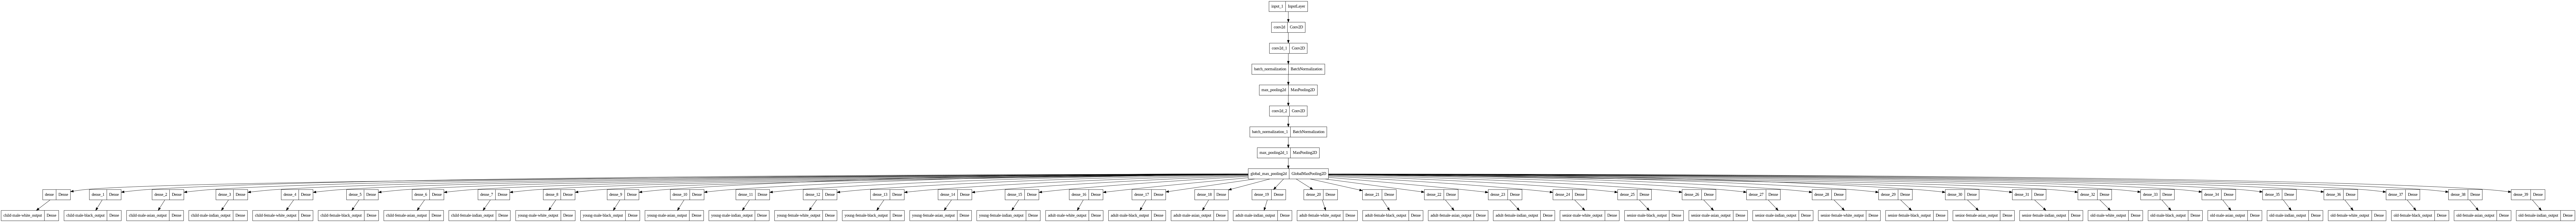

In [27]:
# model declaration 
model_unbal = Model(inputs=input_layer, 
                    outputs=outputs)
              
model_unbal.compile(optimizer='rmsprop', 
                    loss=loss,
                    loss_weights=loss_w,
                    metrics=metr)
model_unbal.summary()
plot_model(model_unbal, "Unbalanced model.png")

In [28]:
# Data preparartion for training

batch_size = 4
train_gen = get_data_generator(X_train_cnn, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(X_val_cnn, for_training=True, batch_size=batch_size)
test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=batch_size)

In [1]:
# TRAINING
callbacks = [ModelCheckpoint(MODEL_CHKP_CNN_PATH + 'b64_4convs', monitor='val_loss')]

history = model_unbal.fit(train_gen,
                          epochs=5,
                          steps_per_epoch=20,       #len(X_train_cnn)//batch_size,
                          callbacks=callbacks,
                          validation_data=valid_gen,
                          validation_steps=len(X_val_cnn)//batch_size)

NameError: ignored

In [ ]:
# SAVE HISTORY
with open(MODEL_CHKP_CNN_PATH + '/cnn_history.pkl', 'wb') as f:
    pickle.dump(history, f)

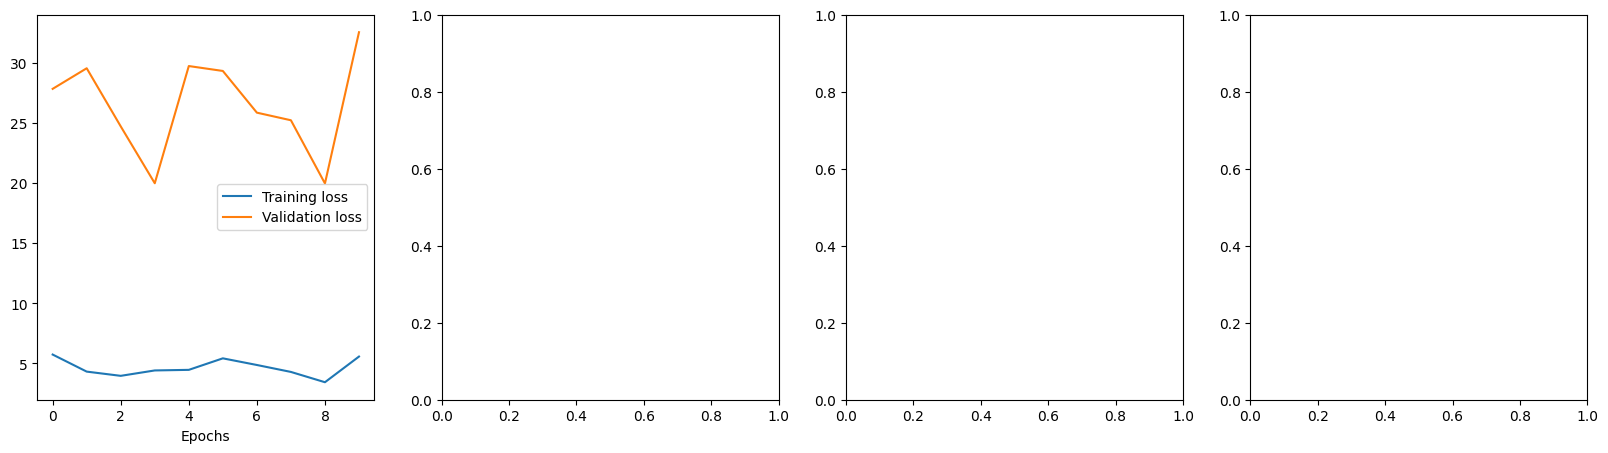

In [ ]:
# PLOT LOSSES
def  plot_train_loss(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # total loss
    axes[0].plot(history.history['loss'], label='Training loss')
    axes[0].plot(history.history['val_loss'], label='Validation loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

'''    # age loss
    axes[1].plot(history.history['age_output_loss'], label='Age Train loss')
    axes[1].plot(history.history['val_age_output_loss'], label='Age Val loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend() 

    # gender loss
    axes[2].plot(history.history['gender_output_loss'], label='Gender Train loss')
    axes[2].plot(history.history['val_gender_output_loss'], label='Gener Val loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    # race loss
    axes[3].plot(history.history['race_output_loss'], label='Race Train loss')
    axes[3].plot(history.history['val_race_output_loss'], label='Race Val loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()
'''    
try: 
  if history:
    plot_train_loss(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '/cnn_history.pkl','rb'))
  plot_train_loss(h)

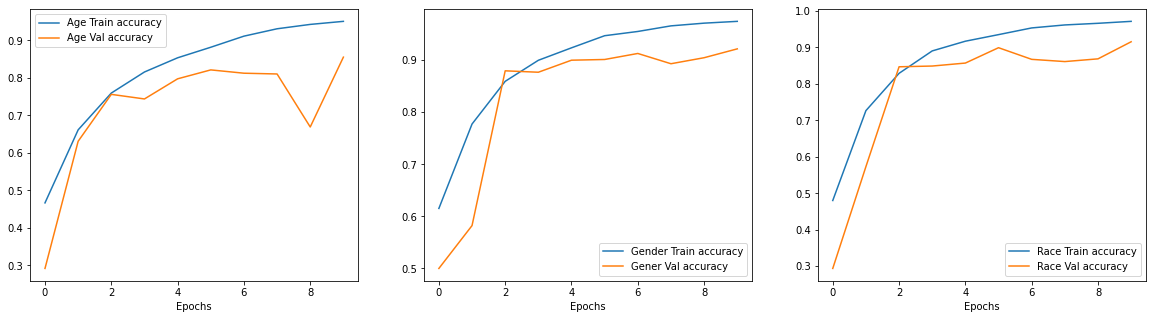

In [ ]:
# PLOT ACCURACY
def  plot_train_accuracy(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # age accuracy
    axes[0].plot(history.history['age_output_accuracy'], label='Age Train accuracy')
    axes[0].plot(history.history['val_age_output_accuracy'], label='Age Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    # gender accuracy
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    # race accuracy
    axes[2].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[2].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()
try: 
  if history:
    plot_train_accuracy(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '/cnn_history.pkl','rb'))
  plot_train_accuracy(h)

In [ ]:
# LOAD MODEL (only if necessary)
model_unbal = load_model(MODEL_CHKP_CNN_PATH, compile=True)
batch_size = 128
test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=batch_size)

In [ ]:
# TEST 
dict(zip(model_unbal.metrics_names, 
         model_unbal.evaluate(test_gen, steps=len(X_test_cnn)//batch_size)))

38/38 [==============================] - 16s 415ms/step - loss: 1.7057 - age_output_loss: 0.7891 - gender_output_loss: 0.2775 - race_output_loss: 0.6390 - age_output_accuracy: 0.7712 - gender_output_accuracy: 0.8970 - race_output_accuracy: 0.8082


{'age_output_accuracy': 0.7711759805679321,
 'age_output_loss': 0.7891385555267334,
 'gender_output_accuracy': 0.8969983458518982,
 'gender_output_loss': 0.27754318714141846,
 'loss': 1.7056620121002197,
 'race_output_accuracy': 0.8081825375556946,
 'race_output_loss': 0.6389800906181335}

In [ ]:
# METRICS
test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=512)
x_test, attr_list = next(test_gen)

age_pred, gender_pred, race_pred = model_unbal.predict_on_batch(x_test)

age_true, gender_true, race_true = attr_list[0].argmax(axis=-1), attr_list[1].argmax(axis=-1), attr_list[2].argmax(axis=-1)
age_pred, gedner_pred, race_pred = age_pred.argmax(axis=-1), gender_pred.argmax(axis=-1), race_pred.argmax(axis=-1)

In [ ]:
def normalize_gender_prediction(gender_pred):
    gender_pred_norm = []
    for prediction in gender_pred:
      if prediction[0] > prediction[1]:
        gender_pred_norm.append(0)
      else:
        gender_pred_norm.append(1)
    return np.array(gender_pred_norm)

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for age")
print(classification_report(age_true, age_pred))

print("\nClassification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, normalize_gender_prediction(gender_pred)))

Classification report for age
              precision    recall  f1-score   support

           0       0.97      0.76      0.85        83
           1       0.57      0.11      0.18        73
           2       0.76      0.95      0.84       320
           3       0.30      0.29      0.30        24
           4       0.80      0.67      0.73        12

    accuracy                           0.76       512
   macro avg       0.68      0.55      0.58       512
weighted avg       0.75      0.76      0.72       512


Classification report for race
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       252
           1       0.74      0.90      0.82       103
           2       0.72      0.94      0.81        79
           3       0.61      0.73      0.66        78

    accuracy                           0.79       512
   macro avg       0.76      0.82      0.78       512
weighted avg       0.83      0.79      0.80       512


Classificatio

####Balanced

In [ ]:
# BALANCING
# Before balancing, change dataset link 
# Groupby for columns: it returns 40 combinations
# Resampling with 400 items for group, with replacement and a specific seed

utkface_bal = utkface_df.copy()
utkface_bal = utkface_bal.groupby(['gender', 'race', 'age']).sample(500, replace=True, random_state=123)
utkface_bal.groupby(['gender', 'race', 'age']).size()

gender  race  age
0       0     0      500
              1      500
              2      500
              3      500
              4      500
        1     0      500
              1      500
              2      500
              3      500
              4      500
        2     0      500
              1      500
              2      500
              3      500
              4      500
        3     0      500
              1      500
              2      500
              3      500
              4      500
1       0     0      500
              1      500
              2      500
              3      500
              4      500
        1     0      500
              1      500
              2      500
              3      500
              4      500
        2     0      500
              1      500
              2      500
              3      500
              4      500
        3     0      500
              1      500
              2      500
              3      500
       

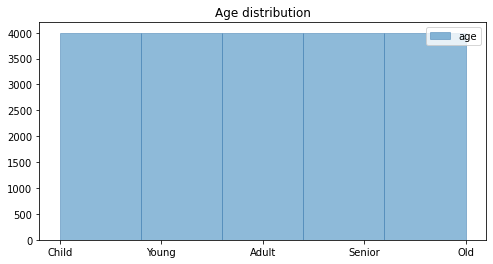

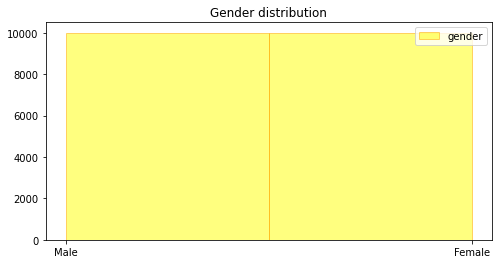

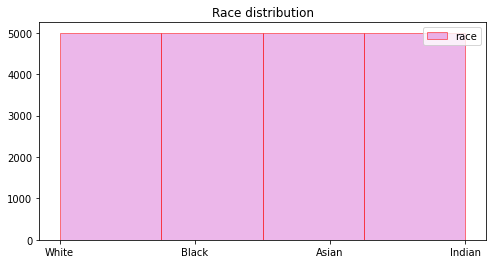

In [ ]:
# DISTRIBUTIONS AFTER BALANCING 
plot_distr(utkface_bal)

In [ ]:
utkface_bal.head()

,age,gender,race
8_0_0_20170110220350538.jpg.chip.jpg,0,0,0
7_0_0_20170110215645684.jpg.chip.jpg,0,0,0
4_0_0_20170110213542396.jpg.chip.jpg,0,0,0
5_0_0_20170110215925587.jpg.chip.jpg,0,0,0
10_0_0_20170110221811823.jpg.chip.jpg,0,0,0


In [ ]:
# SAVE BALANCED DATA 
attr_dict_bal = utkface_bal.to_csv('attr_bal.csv')

In [ ]:
# split training/testing/validation
X_train_bal, X_test_bal = train_test_split(utkface_bal, test_size = 0.30, random_state = 123)
X_test_bal, X_val_bal = train_test_split(X_test_bal, test_size = 0.25, random_state = 123)

print('Number of total samples:         ', utkface_bal.shape[0])
print('Number of elements in train set: ', X_train_bal.shape[0])
print('Number of elements in test set:  ', X_test_bal.shape[0])
print('Number of elements in val set:   ', X_val_bal.shape[0])

Number of total samples:          20000
Number of elements in train set:  14000
Number of elements in test set:   4500
Number of elements in val set:    1500


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

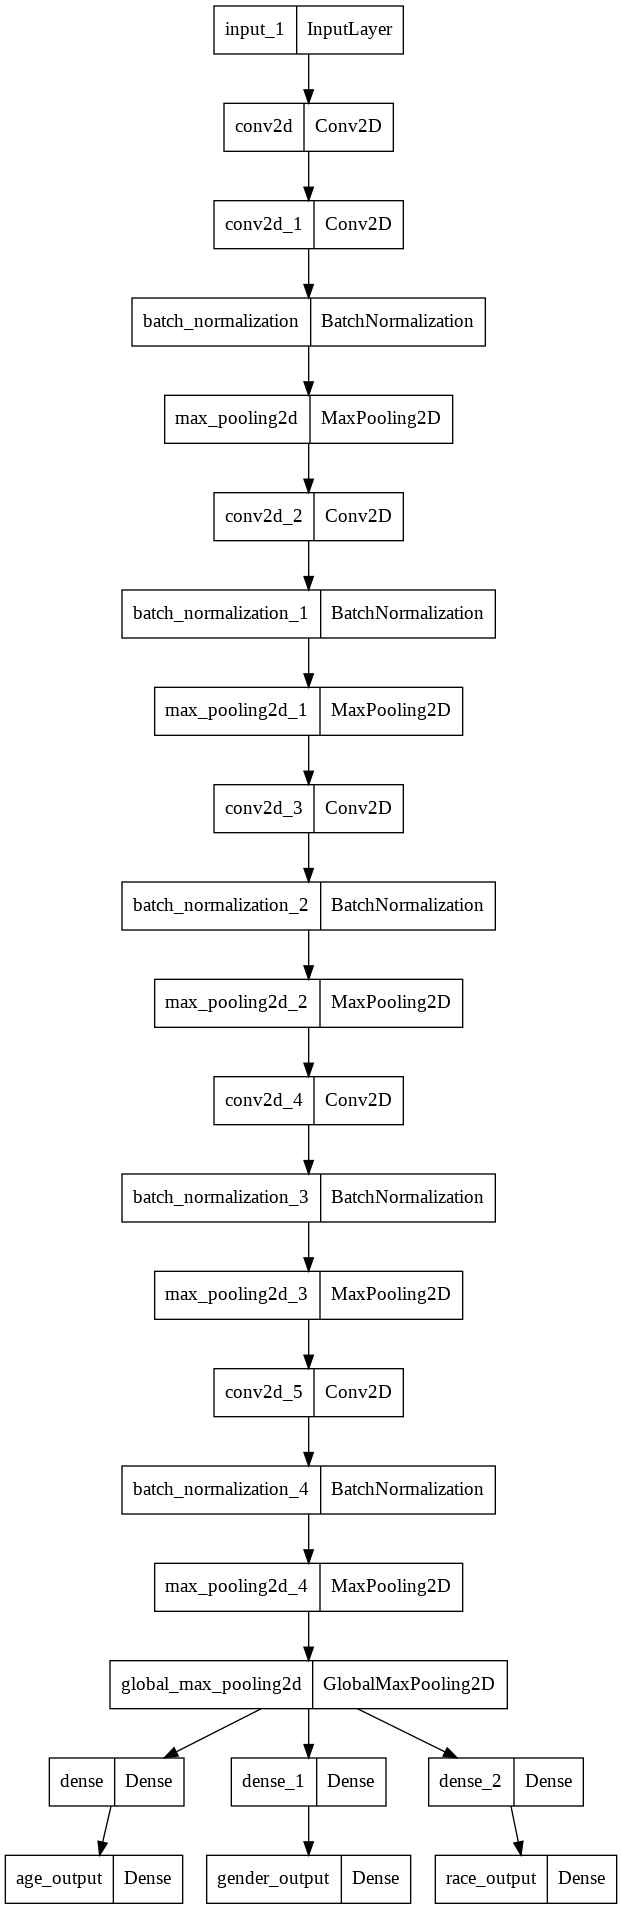

In [ ]:
model_bal = Model(inputs=input_layer, 
                  outputs=[age_output, gender_output, race_output])
              
model_bal.compile(optimizer='rmsprop', 
                  loss={'age_output': 'categorical_crossentropy',
                        'gender_output': 'categorical_crossentropy', 
                        'race_output': 'categorical_crossentropy'},
                  loss_weights={'age_output': 1, 
                                'gender_output': 1,
                                'race_output': 1},
                  metrics={'age_output': 'accuracy', 
                          'gender_output': 'accuracy', 
                          'race_output': 'accuracy'})
model_bal.summary()
plot_model(model_bal, "model_bal.png")

In [ ]:
# Data preparartion for training

batch_size = 64
train_gen_bal = get_data_generator(X_train_bal, for_training=True, batch_size=batch_size)
valid_gen_bal = get_data_generator(X_val_bal, for_training=True, batch_size=batch_size)
test_gen_bal = get_data_generator(X_test_bal, for_training=False, batch_size=batch_size)

In [ ]:
# TRAINING
callbacks = [ModelCheckpoint(MODEL_CHKP_CNN_PATH + '_bal', monitor='val_loss')]

history = model_bal.fit(train_gen_bal,
                        epochs=10,
                        #steps_per_epoch=len(X_train_bal)//batch_size,
                        steps_per_epoch=240,
                        callbacks=callbacks,
                        validation_data=valid_gen_bal,
                        validation_steps=len(X_val_bal)//batch_size)

Epoch 1/10
240/240 [==============================] - 96s 332ms/step - loss: 3.3106 - age_output_loss: 1.3131 - gender_output_loss: 0.7437 - race_output_loss: 1.2538 - age_output_accuracy: 0.4669 - gender_output_accuracy: 0.6151 - race_output_accuracy: 0.4798 - val_loss: 4.6658 - val_age_output_loss: 1.6756 - val_gender_output_loss: 1.4773 - val_race_output_loss: 1.5129 - val_age_output_accuracy: 0.2921 - val_gender_output_accuracy: 0.5000 - val_race_output_accuracy: 0.2935
Epoch 2/10
240/240 [==============================] - 72s 300ms/step - loss: 1.9581 - age_output_loss: 0.7822 - gender_output_loss: 0.4657 - race_output_loss: 0.7102 - age_output_accuracy: 0.6615 - gender_output_accuracy: 0.7770 - race_output_accuracy: 0.7262 - val_loss: 2.5440 - val_age_output_loss: 0.8486 - val_gender_output_loss: 0.7426 - val_race_output_loss: 0.9528 - val_age_output_accuracy: 0.6311 - val_gender_output_accuracy: 0.5822 - val_race_output_accuracy: 0.5727
Epoch 3/10
240/240 [======================

In [ ]:
# SAVE HISTORY
with open(MODEL_CHKP_CNN_PATH + '_bal' + '/cnn_history.pkl', 'wb') as f:
    pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://e2cf2581-da8a-4b60-886f-55e2d5406db0/assets


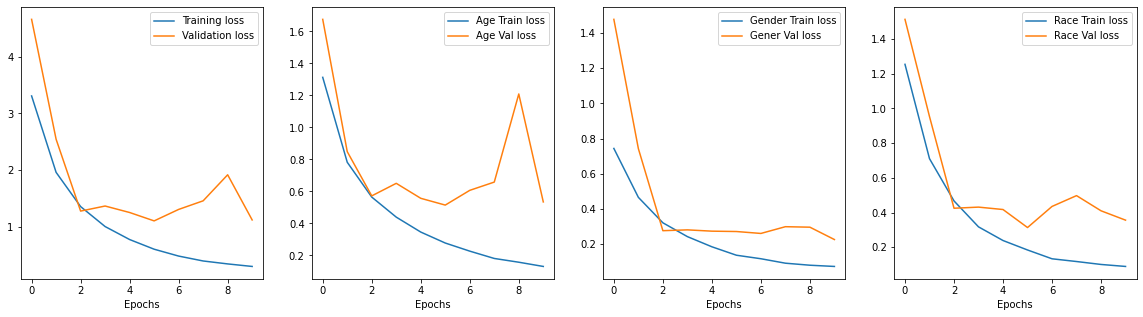

In [ ]:
# PLOT LOSSES
try: 
  if history:
    plot_train_loss(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '_bal' + '/cnn_history.pkl','rb'))
  plot_train_loss(h)

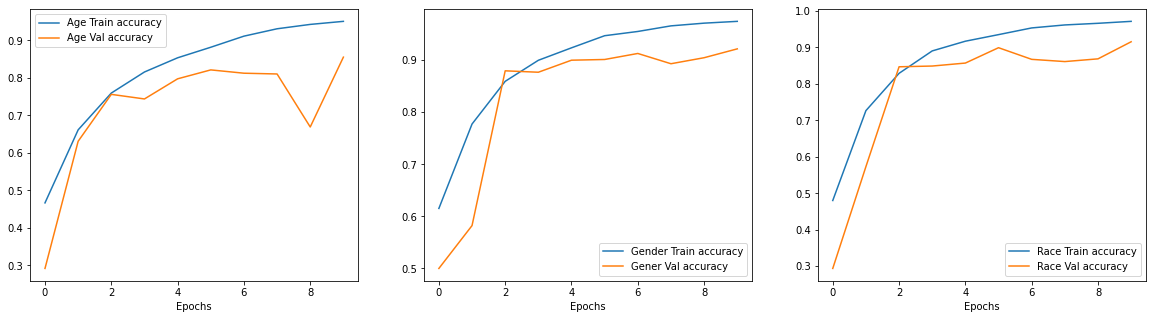

In [ ]:
# PLOT ACCURACY
try: 
  if history:
    plot_train_accuracy(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '_bal' + '/cnn_history.pkl','rb'))
  plot_train_accuracy(h)

In [ ]:
# LOAD MODEL (only if necessary)
model_bal = load_model(MODEL_CHKP_CNN_PATH + '_bal', compile=True)
batch_size = 128
test_gen_bal = get_data_generator(X_test_bal, for_training=False, batch_size=batch_size)

In [ ]:
# TEST 
dizzi = dict(zip(model_bal.metrics_names, 
         model_bal.evaluate(test_gen_bal, steps=len(X_test_bal)//batch_size)))

35/35 [==============================] - 16s 442ms/step - loss: 1.0858 - age_output_loss: 0.4540 - gender_output_loss: 0.2278 - race_output_loss: 0.4040 - age_output_accuracy: 0.8636 - gender_output_accuracy: 0.9259 - race_output_accuracy: 0.9076


In [ ]:
test_gen_bal = get_data_generator(X_test_bal, for_training=False, batch_size=128)
dict(zip(model_bal.metrics_names, model_bal.evaluate_generator(test_gen_bal, steps=len(X_test_bal)//128)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


{'age_output_accuracy': 0.8636160492897034,
 'age_output_loss': 0.453971266746521,
 'gender_output_accuracy': 0.9258928298950195,
 'gender_output_loss': 0.22778108716011047,
 'loss': 1.0857969522476196,
 'race_output_accuracy': 0.9075892567634583,
 'race_output_loss': 0.40404462814331055}

In [ ]:
# METRICS
test_gen_bal = get_data_generator(X_test_bal, for_training=False, batch_size=512)
x_test_bal, attr_list_bal= next(test_gen_bal)

age_pred_bal, gender_pred_bal, race_pred_bal = model_bal.predict_on_batch(x_test_bal)

In [ ]:
age_true_bal, gender_true_bal, race_true_bal = attr_list_bal[0].argmax(axis=-1), attr_list_bal[1].argmax(axis=-1), attr_list_bal[2].argmax(axis=-1)
age_pred_bal, gedner_pred_bal, race_pred_bal = age_pred_bal.argmax(axis=-1), gender_pred_bal.argmax(axis=-1), race_pred_bal.argmax(axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for age")
print(classification_report(age_true_bal, age_pred_bal))

print("\nClassification report for race")
print(classification_report(race_true_bal, race_pred_bal))

print("\nClassification report for gender")
print(classification_report(gender_true_bal, normalize_gender_prediction(gender_pred_bal)))

Classification report for age
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       102
           1       0.86      0.84      0.85        94
           2       0.82      0.82      0.82       111
           3       0.93      0.95      0.94       113
           4       0.98      0.97      0.97        92

    accuracy                           0.91       512
   macro avg       0.91      0.91      0.91       512
weighted avg       0.91      0.91      0.91       512


Classification report for race
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       123
           1       0.90      0.94      0.92       156
           2       0.98      0.89      0.93       120
           3       0.85      0.86      0.85       113

    accuracy                           0.90       512
   macro avg       0.90      0.90      0.90       512
weighted avg       0.90      0.90      0.90       512


Classificatio

### Image Detection test

In [ ]:
import math

ID_AGE_MAP = {0: 'children', 1: 'young', 2:'adult', 3:'senior', 4:'old'}
AGE_ID_MAP = dict((a, i) for i, a in ID_AGE_MAP.items())
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

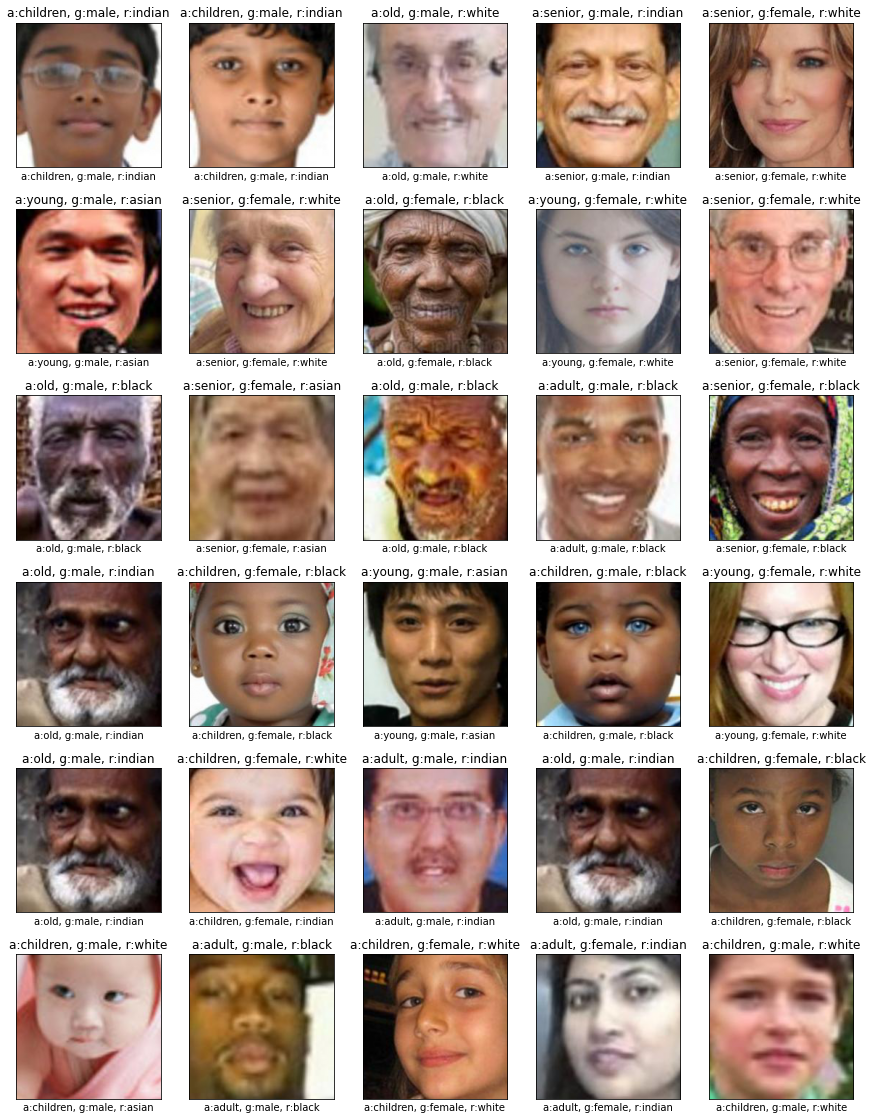

In [ ]:
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test_bal[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(ID_AGE_MAP[age_pred_bal[img_idx]], 
                                           ID_GENDER_MAP[normalize_gender_prediction(gender_pred_bal)[img_idx]], 
                                           ID_RACE_MAP[race_pred_bal[img_idx]]))
    
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(ID_AGE_MAP[age_pred_bal[img_idx]], 
                                            ID_GENDER_MAP[normalize_gender_prediction(gender_pred_bal)[img_idx]], 
                                            ID_RACE_MAP[race_true_bal[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])